<a href="https://colab.research.google.com/github/Jade-Cartagena/QSAR-QSPR-Predictive-Models/blob/Predictive-Models/Non_Linear_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, precision_recall_curve, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

[09:54:45] WARNING: not removing hydrogen atom without neighbors



=== SVM Model for Antioxidant Prediction ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Cross-validated Accuracy: 0.8767714109673443
Cross-validated ROC AUC: 0.9314099855319706
Best Parameters: {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'class_weight': 'balanced', 'C': 1}
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       416
           1       0.93      0.80      0.86       396

    accuracy                           0.87       812
   macro avg       0.88      0.87      0.87       812
weighted avg       0.88      0.87      0.87       812

Accuracy: 0.8719211822660099
ROC AUC: 0.933423781080031


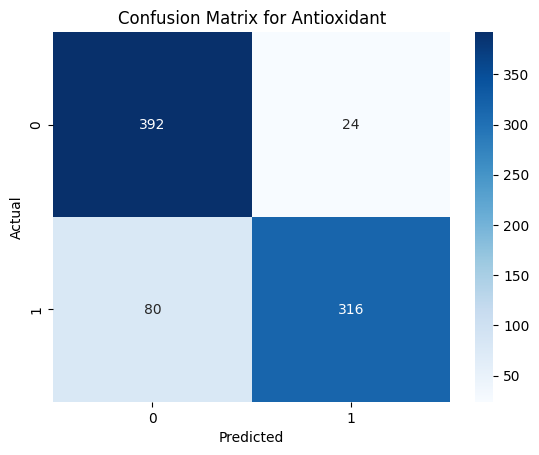

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [ ]:
# === Load and preprocess data ===
df = pd.read_csv("/content/QSAR-QSPR Finalized Dataset.csv")
smiles_list = df["SMILES"].tolist()

# Generate Morgan fingerprints
generator = GetMorganGenerator(radius=2, fpSize=2048)
fps = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fp = generator.GetFingerprint(mol)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        fps.append(arr)
    else:
        fps.append(np.zeros((2048,), dtype=int))

fps_np = np.array(fps)

# Clean and prepare the dataset
df = df.drop(columns=["SMILES", "IUPAC_NAME", "NAME"])
target_cols = ['Antioxidant', 'Anti-inflammatory', 'Toxic']
df[target_cols] = df[target_cols].astype(int)

# Descriptor + fingerprint feature matrix
features = df.drop(columns=target_cols).select_dtypes(include='number')
features_imputed = KNNImputer(n_neighbors=5).fit_transform(features)
X_scaled = StandardScaler().fit_transform(features_imputed)
X_combined = np.hstack([X_scaled, fps_np])

# === Modeling for each target ===
for target in target_cols:
    print(f"\n=== SVM Model for {target} Prediction ===")

    y = df[target]

    # Feature selection
    selector = SelectKBest(score_func=f_classif, k=min(1000, int(X_combined.shape[1] * 0.5)))
    X_selected = selector.fit_transform(X_combined, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

    # Hyperparameter tuning
    param_dist = {
        'C': [0.01, 0.1, 1],
        'kernel': ['rbf', 'poly'],
        'gamma': ['scale', 0.01],
        'degree': [2, 3],
        'class_weight': ['balanced'],
        'probability': [True]
    }

    model = SVC(random_state=42)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=15, cv=cv, verbose=1, n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=3) # Changed cv to 3 to match calibrated_model
    print("Cross-validated Accuracy:", cv_scores.mean())
    cv_roc_auc = cross_val_score(best_model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    print("Cross-validated ROC AUC:", cv_roc_auc.mean())

    # Prediction
    y_prob = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    # === Evaluation ===
    print("Best Parameters:", search.best_params_)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Feature Importance
    importances = best_model.feature_importances_
    feat_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
    plt.title(f"Top 10 Features for {target}")
    plt.tight_layout()
    plt.show()

    # PR Curve
    precisions, recalls, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recalls, precisions, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {target}")
    plt.legend()
    plt.grid()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {target}")
    plt.legend()
    plt.grid()
    plt.show()
